### Sleep spindle activities detection

Steps:

1. 10~15 Hz bandfilter, optional frequency range
2. Calculate squared (emphasize the difference between real value and minimum value) spindle band power
3. Find peaks higher than a threshold
4. Find the two minimum value around the peak
5. Add duration threshold for the two minimum value
6. Some special occasions (e.g. two peaks distance is shorter than 1s, we think it's the same spindle)


In [55]:
import misleep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [56]:
midata = misleep.load_mat(data_path=r'E:/workplace/EEGProcessing/00_DATA/20240114_17_0700_7pin/female2/female2_305.mat')
# mianno = misleep.load_misleep_anno(r'\\172.16.41.188\wangxueqiang\EEG_data\TechMan\20240524_190000\label.txt')

In [57]:
example_data = midata.pick_chs(['EEG_F_R'])
example_data.filter(chans=['EEG_F_R'])
example_data = example_data.pick_chs(['EEG_F_R_bandpass_0.5_30'])
example_data = example_data.crop([19270, 19300])

sf = example_data.sf[0]
example_data = example_data.signals[0]

#### Do 10~15 Hz bandpass filter

In [58]:
spindle_data, _ = misleep.signal_filter(example_data, sf, btype='bandpass', low=10, high=15)

#### Calculate the square spindle power

In [83]:
# get power with sfft
f, t, Sxx = misleep.spectrogram(example_data, sf, band=[10, 15], step=0.05, window=2, norm=False)

In [84]:
Sxx = np.sum(Sxx, axis=0)
Sxx_squared = Sxx ** 2

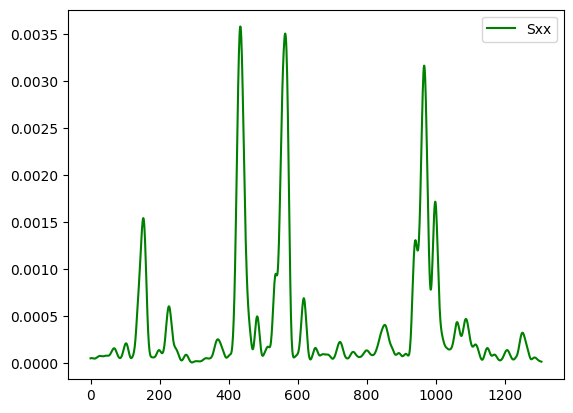

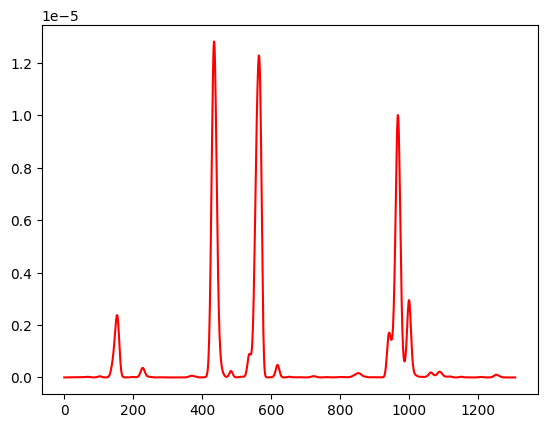

In [61]:
# Why use square
plt.plot(Sxx, color='green', label='Sxx')
plt.legend()
plt.show()

plt.plot(Sxx_squared, color='red', label='Sxx_squared')


#### Use threshold to find peaks

In [85]:
# Use z score to find the real value for threshold
Sxx = Sxx_squared
Sxx_mean = np.mean(Sxx)
Sxx_std = np.std(Sxx)
spindle_threshold = 2*Sxx_std + Sxx_mean

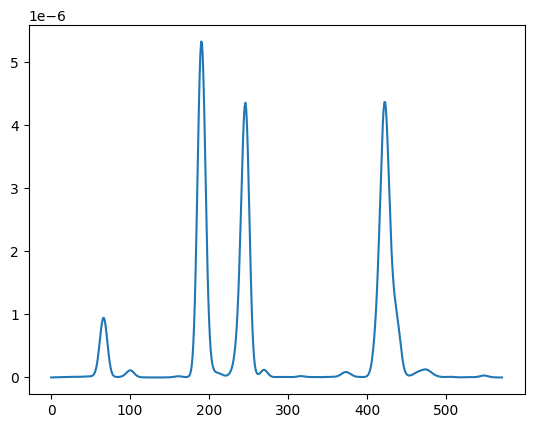

In [86]:
plt.plot(Sxx)

In [87]:
Sxx_mean = np.mean(Sxx)
Sxx_std = np.std(Sxx)
spindle_threshold = 0.5*Sxx_std + Sxx_mean
Sxx_peaks_idx, Sxx_peaks_value = find_peaks(Sxx, (spindle_threshold))

In [24]:
Sxx_peaks_idx.shape == (0, )

False

In [51]:
Sxx_peaks_idx

array([435, 562, 966], dtype=int64)

#### Use another threshold for duration

In [88]:
duration_threshold = 0.2*Sxx_std + Sxx_mean
# duration_idx = np.logical_and()

In [37]:
Sxx.shape

(1308,)

In [89]:
duration_group = misleep.lst2group([[idx, each] for idx, each in enumerate(Sxx > duration_threshold)])
start_time = []
end_time = []
for each in duration_group:
    if each[0] != 0 and each[2]:
        for peak_idx in Sxx_peaks_idx:
            if peak_idx < each[1] and peak_idx > each[0]:
                start_time.append(t[each[0]])
                end_time.append(t[each[1]])

start_time = np.array(start_time)
end_time = np.array(end_time)

In [25]:
# find the minimum peak for duration 
minimum_peaks_idx = find_peaks(-1*Sxx)[0]

In [26]:
Sxx_peaks_idx

array([435, 562, 966], dtype=int64)

In [27]:
# find the minimum peak around the Sxx peak
if minimum_peaks_idx[-1] < Sxx_peaks_idx[-1]:
    minimum_peaks_idx = np.append(minimum_peaks_idx, Sxx_peaks_idx[-1]+1)

end_minimun_sorted_idx = np.searchsorted(minimum_peaks_idx, Sxx_peaks_idx)

end_minimum_peak_idx = minimum_peaks_idx[end_minimun_sorted_idx]

if end_minimun_sorted_idx[0] == 0:
    end_minimun_sorted_idx = end_minimun_sorted_idx[1:]
    start_minimum_peak_idx = minimum_peaks_idx[end_minimun_sorted_idx-1]
    start_minimum_peak_idx = np.append(0, start_minimum_peak_idx)

else:
    start_minimum_peak_idx = minimum_peaks_idx[end_minimun_sorted_idx-1]


In [28]:
# get time index based on peak index
start_minimum_t = t[start_minimum_peak_idx]
end_minimum_t = t[end_minimum_peak_idx]
Sxx_peak_t = t[Sxx_peaks_idx]

In [29]:
start_minimum_t + 30

array([38.95081967, 41.59016393, 50.70163934])

In [30]:
np.diff(Sxx_peak_t)

array([2.9147541 , 9.27213115])

#### Add time duration threshold

In [90]:
spindle_lst = np.array([start_time, end_time]).T
spindle_lst

array([[ 3.25245902,  3.72459016],
       [ 9.49508197, 10.59672131],
       [12.27540984, 13.4295082 ],
       [21.4557377 , 23.18688525]])

#### Plot 

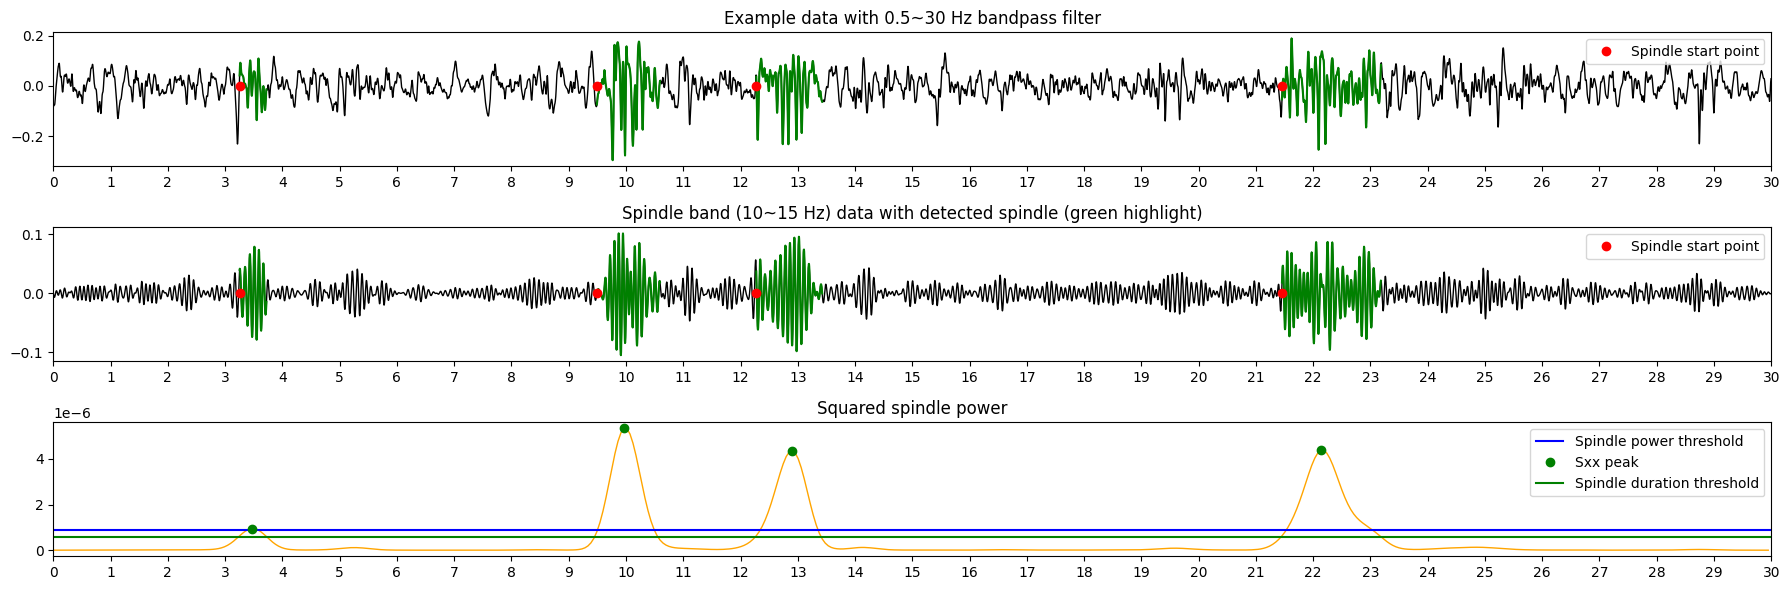

In [92]:
fig = plt.figure(figsize=(18, 6))
axs = fig.subplots(nrows=3, ncols=1)
fig.set_tight_layout(2)

axs[0].plot(example_data, color='black', linewidth=1)
[axs[0].plot(range(int(each*sf), int(end_time[idx]*sf)), example_data[int(each*sf): int(end_time[idx]*sf)], color='green') 
 for idx, each in enumerate(start_time)]
axs[0].plot(start_time*sf, [0]*len(start_time), 'ro', label='Spindle start point')
axs[0].set_title('Example data with 0.5~30 Hz bandpass filter')
axs[0].set_xlim(0, len(example_data))
axs[0].set_xticks(range(0, len(example_data)+1, int(sf)), range(0, 31, 1))
axs[0].legend(loc='upper right')

axs[1].plot(spindle_data, color='black', linewidth=1)
[axs[1].plot(range(int(each*sf), int(end_time[idx]*sf)), spindle_data[int(each*sf): int(end_time[idx]*sf)], color='green') 
 for idx, each in enumerate(start_time)]
axs[1].plot(start_time*sf, [0]*len(start_time), 'ro', label='Spindle start point')
axs[1].set_title('Spindle band (10~15 Hz) data with detected spindle (green highlight)')
axs[1].set_xlim(0, len(spindle_data))
axs[1].legend()
axs[1].set_xticks(range(0, len(spindle_data)+1, int(sf)), range(0, 31, 1))

axs[2].plot(Sxx_squared, color='orange', linewidth=1)
axs[2].set_title('Squared spindle power')
axs[2].axhline(spindle_threshold, color='blue', label='Spindle power threshold')
axs[2].set_xlim(0, len(Sxx_squared))
axs[2].plot(Sxx_peaks_idx, Sxx_peaks_value['peak_heights'], 'go', label='Sxx peak')
# axs[2].plot(minimum_peaks_idx, Sxx_squared[minimum_peaks_idx], 'ro', label='minimum peak')
axs[2].axhline(duration_threshold, color='green', label='Spindle duration threshold')
axs[2].legend()
axs[2].set_xticks(np.linspace(0, len(t), 31), range(0, 31))
plt.show()
